This notebook is largely a clearning of the Cellular Automata (Infinite Data) notebook. 

The intention here is to write code which properly assesses the accuracy of the model on individual programmes continually throughout the training process. Ideally, this would give visual evidence of the kind of grokking behaviour which I expect.

In [1]:
# Importing necessary libraries

!pip install cellpylib

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time
import math
import matplotlib.cm as cm # For colourmap plots later
from tqdm import tqdm

  Using cached cellpylib-2.4.0.tar.gz (38 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cellpylib: filename=cellpylib-2.4.0-py3-none-any.whl size=37931 sha256=3fa30601a2fb8f1b774811a63ed82a61f7f3b20a27fefca4dafab7fffc2bc264
  Stored in directory: c:\users\plogo\appdata\local\pip\cache\wheels\90\db\81\70a63e7c4de08d29f2b1d988ca055bff567bf53439f00e0f3c
Successfully built cellpylib


In [2]:
# Set Parameters

# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model
num_epochs = 30000  # Number of training epochs
hidden_size = 512  # Update with the desired size of the hidden layer
learning_rate = 0.005 # learning rate used later in the optimizer
batch_size = 128 # Batch size used when creating the train and test datasets. 32 is more suitable for this problem.
epochs = np.arange(0,num_epochs, 1) # Used in plotting
accuracy_frequency = 200 # Used in the evaluation of the model

In [3]:
# Programme distribution functions. Note that these distributions can all be normalised later

def prog_dist_inverse():
    # Gives a 1/x like distribution for programmes, favouring smaller programmes
    programmes_prob_distribution = []
    for i in range(256):
        programmes_prob_distribution.append((i+10)**(-1))
    programmes_prob_distribution = np.array(programmes_prob_distribution) 
    return programmes_prob_distribution

def prog_dist_inverse_rev():
    # Gives a 1/x like distribution such that the pole is at the 255 end. Favours larger programmes. An exact swap of prog_dist_inverse
    programmes_prob_distribution = np.zeros(256)
    for i in range(256):
        programmes_prob_distribution[255 - i] = (i+10)**(-1)
    return programmes_prob_distribution

def prog_dist_bell(mean, stddev):
    # Gives a programmes distribution like a bell curve, with the mean and standard deviation specified in the arguments. 
    # Ideally somewhat more symmetric around a region of interest
    programmes_prob_distribution = np.zeros(256)
    for i in range(256):
        normal_val = np.exp(-1/2 * ((i - mean)/stddev)**2) #normalisation is not necessary here
        programmes_prob_distribution[i] = normal_val
    return programmes_prob_distribution

def prog_dist_reg():
    # Gives a list of programmes, regualarly spaced, and randomly samples from them. This means that the majority of programmes will never be sampled
    prog_list = np.arange(0, 256, 20) #Results in [  0  20  40  60  80 100 120 140 160 180 200 220 240] for np.arange(0, 256, 20)
    programmes_prob_distribution = np.zeros(256)
    for prog in prog_list:
        programmes_prob_distribution[prog] = 1
    return programmes_prob_distribution

def prog_dist_indep(): # gives a uniform distribution over the list indep_list
    indep_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38,
              40, 41, 42, 43, 44, 45, 46, 50, 51, 54, 56, 57, 58, 60, 62, 72, 73, 74, 76, 77, 78, 90, 94, 104, 105, 106, 108, 110, 122, 126, 
              128, 130, 132, 134, 136, 138, 140, 142, 146, 150, 152, 154, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232]
    prog_list = np.zeros(256)
    for index, item in enumerate(indep_list):
        prog_list[item] = 1
    return prog_list

def prog_dist_hardlearned(): # gives a uniform distribution over the list uncorr
    hard_learned = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 19, 22, 23, 24, 26, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 
                    44, 45, 46, 51, 54, 56, 60, 72, 73, 74, 76, 78, 90, 104, 106, 108, 110, 122, 126, 128, 130, 132, 134, 138, 140, 142, 
                    146, 150, 152, 154, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232]
    prog_list = np.zeros(256)
    for index, item in enumerate(hard_learned):
        prog_list[item] = 1
    return prog_list

def prog_dist_uncorr(): # gives a uniform distribution over the list uncorr
    uncorr = [0, 30, 55, 90, 124, 158, 188, 202, 219, 221, 248] # a list of quite arbitrary programmes which are broadly speaking not correlated
    prog_list = np.zeros(256)
    for index, item in enumerate(uncorr):
        prog_list[item] = 1
    return prog_list

def prog_dist_antiweight_autocorr(): # Takes the autocorrelations of programmes, and makes less autocorrelation programmes more common
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (autocorrelation + 1)**(-3)
    return prog_list

def prog_dist_weight_autocorr(): # NOTE: UNTESTED. Takes the aurocorrelations of programmes, and makes more autocorrelated programmes more commmon (almost like the proper weighting)
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (autocorrelation + 1)**(3)
    return prog_list

def prog_dist_weight_hierarchicalclustering():
    hierarchical_clustering_order = [96, 0, 160, 32, 224, 192, 8, 136, 40, 168, 64, 128, 164, 36, 104, 6, 20, 18, 146, 5, 17, 196, 3, 48, 10, 
                                     12, 34, 68, 80, 140, 134, 148, 38, 52, 33, 108, 74, 88, 172, 228, 4, 72, 1, 2, 16, 44, 100, 144, 130, 132, 
                                     194, 66, 24, 152, 41, 97, 7, 21, 37, 26, 82, 98, 56, 200, 116, 138, 208, 163, 76, 42, 46, 112, 177, 22, 
                                     131, 145, 35, 49, 162, 176, 19, 133, 9, 65, 11, 81, 25, 67, 141, 13, 69, 197, 137, 193, 147, 143, 157, 109, 
                                     199, 213, 126, 57, 226, 129, 161, 23, 232, 184, 122, 142, 83, 27, 39, 71, 102, 99, 86, 204, 153, 180, 210, 
                                     105, 212, 15, 53, 50, 60, 85, 89, 225, 29, 149, 169, 45, 156, 106, 165, 150, 51, 120, 135, 154, 30, 75, 198,
                                     178, 179, 43, 90, 101, 170, 166, 77, 113, 195, 240, 54, 70, 73, 28, 14, 84, 87, 31, 107, 121, 181, 91, 167, 
                                     236, 185, 227, 209, 244, 139, 241, 58, 174, 205, 114, 171, 151, 62, 118, 59, 115, 186, 242, 55, 111, 94, 
                                     125, 47, 61, 103, 117, 110, 124, 93, 92, 78, 79, 248, 250, 252, 234, 254, 251, 239, 235, 255, 249, 238, 
                                     253, 218, 219, 233, 159, 215, 182, 183, 95, 119, 207, 63, 220, 206, 175, 221, 243, 187, 245, 158, 214, 155, 
                                     211, 123, 201, 173, 229, 237, 127, 216, 223, 247, 191, 202, 217, 222, 190, 203, 246, 230, 189, 188, 231]
    programmes_prob_distribution = []
    for i in range(256):
        zipf_weight = (hierarchical_clustering_order.index(i) + 10)**(-1)
        programmes_prob_distribution.append(zipf_weight)
    return programmes_prob_distribution

def prog_dist_antiweight_hierarchicalclustering():
    hierarchical_clustering_order = [96, 0, 160, 32, 224, 192, 8, 136, 40, 168, 64, 128, 164, 36, 104, 6, 20, 18, 146, 5, 17, 196, 3, 48, 10, 
                                     12, 34, 68, 80, 140, 134, 148, 38, 52, 33, 108, 74, 88, 172, 228, 4, 72, 1, 2, 16, 44, 100, 144, 130, 132, 
                                     194, 66, 24, 152, 41, 97, 7, 21, 37, 26, 82, 98, 56, 200, 116, 138, 208, 163, 76, 42, 46, 112, 177, 22, 
                                     131, 145, 35, 49, 162, 176, 19, 133, 9, 65, 11, 81, 25, 67, 141, 13, 69, 197, 137, 193, 147, 143, 157, 109, 
                                     199, 213, 126, 57, 226, 129, 161, 23, 232, 184, 122, 142, 83, 27, 39, 71, 102, 99, 86, 204, 153, 180, 210, 
                                     105, 212, 15, 53, 50, 60, 85, 89, 225, 29, 149, 169, 45, 156, 106, 165, 150, 51, 120, 135, 154, 30, 75, 198,
                                     178, 179, 43, 90, 101, 170, 166, 77, 113, 195, 240, 54, 70, 73, 28, 14, 84, 87, 31, 107, 121, 181, 91, 167, 
                                     236, 185, 227, 209, 244, 139, 241, 58, 174, 205, 114, 171, 151, 62, 118, 59, 115, 186, 242, 55, 111, 94, 
                                     125, 47, 61, 103, 117, 110, 124, 93, 92, 78, 79, 248, 250, 252, 234, 254, 251, 239, 235, 255, 249, 238, 
                                     253, 218, 219, 233, 159, 215, 182, 183, 95, 119, 207, 63, 220, 206, 175, 221, 243, 187, 245, 158, 214, 155, 
                                     211, 123, 201, 173, 229, 237, 127, 216, 223, 247, 191, 202, 217, 222, 190, 203, 246, 230, 189, 188, 231]
    programmes_prob_distribution = []
    for i in range(256):
        zipf_weight = (hierarchical_clustering_order.index(255 - i) + 10)**(-1)
        programmes_prob_distribution.append(zipf_weight)
    return programmes_prob_distribution


In [4]:
programmes_prob_distribution = prog_dist_antiweight_hierarchicalclustering()

In [5]:
# Model Initialisation / Training setup

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = 256 #Number of potential classes, here stuck at 256

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
# Defines a way to reset the parameters of a model

def reset_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module.reset_parameters()

In [13]:
# Data generation functions (where the programmes_considered have a probability distribution)

def create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Creating the dataset and labels variables to be populated later
    dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
    labels = np.empty(shape=(1, number_of_samples), dtype=int)

    # Stating the space of considered programmes
    programmes = np.arange(0,256,1)

    # Normalising the distribution in case it is not already normalised
    programmes_total = sum(programmes_prob_distribution)
    programmes_prob_distribution_norm = [x / programmes_total for x in programmes_prob_distribution]
    
    for i in range(number_of_samples):

        # Randomly selecting a rule number according to the probability distribution given
        rule_number = np.random.choice(a = programmes, size=None, replace=True, p = programmes_prob_distribution_norm)
        #print(f"Considering rule_number = ", rule_number)
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
        #print(cellular_automaton[-1])
        dataset[i] = cellular_automaton[-1]
        labels[:,i] = rule_number

    return [dataset, labels]

def data_loader(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Generate the data according to input parameters
    [dataset, labels] = create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps)
    labels = labels[0] # Deal with the fact that the output is a list of a single list

    # Shifting the labels such that they are indexed from 0. Required for cross entropy to work
    #labels = [x - min(labels) for x in labels] #!!! Not currently shifting labels in a test to alter them later - may help with training in smaller batches
    # Use data_split
    data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]

    train_dataset, train_labels = zip(*data)
    
    tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
    
    train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

In [14]:
# Evaluates a model over the space of all possible functions. Outputs a vector giving that performance

def model_evaluation(model, data_size, timesteps, batch_size):

    # State which programmes are being considered. In this case, it's all of them.
    programmes_considered = np.arange(0,256,1) #NOTE: THIS DISABLING IS TEMPORARY. AIM TO REINTRODUCE IT
    #programmes_considered = np.array([0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]) # The programmes used at the moment in autocorrelation

    accuracy_vector = np.empty(256)
    
    for programme in programmes_considered:

        programmes_prob_distribution = [0]*256
        programmes_prob_distribution[programme] = 1

        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, labels in train_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            accuracy = 100 * correct / total #returns the accuracy as a percentage
            #print(f"For programme " + str(programme) + ": Accuracy = " + str(accuracy))
        accuracy_vector[programme] = accuracy
                
    return accuracy_vector

In [15]:
# Training loop (includes data generation). Note that here training and test loss cease to make much sense

def main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs):

    # Initisalise training and test loss tracking variables
    training_loss = np.empty(num_epochs)

    # Initialise an array to track not only the general training and test loss, but also the accuracy on individual programme classification during training.
    # This is to attempt to see grokking.
    # Form: Each row of accuracy_array is an epoch, each column of accuracy_array is a binary 1 or 0 based on whether or not it was correctly classified. 
    #accuracy_frequency = 100 # Once every 100 epochs, the accuracy is measured
    accuracy_array = np.empty((math.floor(num_epochs/accuracy_frequency), 256))
    # Initialising variaable for tracking where in the accuracy_array to write data
    eval_count = 0
    # Each epoch here trains over 1 batch size of data (which at the moment is 32). Each epoch is therefore smaller and better controlled.
    for epoch in tqdm(range(num_epochs)):

        # Continually monitoring accuracy of the model by adjusting the accuracy_array
        if epoch%accuracy_frequency==0:
            accuracy_vector = model_evaluation(model, data_size, timesteps, batch_size)
            accuracy_array[eval_count] = accuracy_vector
            eval_count += 1
        
        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)
        for data, labels in train_loader:
            # Forward pass
            outputs = model(data)
    
            #Shifting labels for loss calculation
            shifted_labels = labels - torch.min(labels)
            shifted_labels = shifted_labels.long()
            loss = criterion(outputs, shifted_labels)
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss after each epoch
        if epoch%1000==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        training_loss[epoch] = loss.item()

    return [training_loss, accuracy_array]

In [16]:
[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)

  0%|          | 0/30000 [00:00<?, ?it/s]C:\Users\plogo\AppData\Local\Temp\ipykernel_16356\2903999265.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_2112s1s0to\croot\pytorch-select_1700158736573\work\torch\csrc\utils\tensor_new.cpp:264.)
  tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
  0%|          | 1/30000 [08:47<4391:56:40, 527.05s/it]

Epoch [1/30000], Loss: 5.522606372833252


  3%|▎         | 1001/30000 [1:21:04<1213:37:58, 150.66s/it]

Epoch [1001/30000], Loss: 5.332419395446777


  7%|▋         | 2001/30000 [2:24:37<963:42:46, 123.91s/it] 

Epoch [2001/30000], Loss: 5.23510217666626


 10%|█         | 3001/30000 [3:25:18<926:44:50, 123.57s/it]

Epoch [3001/30000], Loss: 5.4364333152771


 13%|█▎        | 4001/30000 [4:37:09<1087:18:43, 150.56s/it]

Epoch [4001/30000], Loss: 5.442864894866943


 17%|█▋        | 5001/30000 [5:50:33<843:29:30, 121.47s/it] 

Epoch [5001/30000], Loss: 5.180095672607422


 20%|██        | 6001/30000 [6:57:17<826:42:16, 124.01s/it] 

Epoch [6001/30000], Loss: 5.180517196655273


 23%|██▎       | 7001/30000 [8:28:20<1035:03:05, 162.02s/it]

Epoch [7001/30000], Loss: 5.162910461425781


 27%|██▋       | 8001/30000 [9:43:05<579:42:05, 94.86s/it]  

Epoch [8001/30000], Loss: 5.230904579162598


 30%|███       | 9001/30000 [10:29:34<551:50:37, 94.61s/it]

Epoch [9001/30000], Loss: 5.129530429840088


 33%|███▎      | 10001/30000 [11:18:33<536:14:45, 96.53s/it]

Epoch [10001/30000], Loss: 5.219883918762207


 37%|███▋      | 11001/30000 [12:05:32<505:12:55, 95.73s/it]

Epoch [11001/30000], Loss: 5.179840087890625


 40%|████      | 12001/30000 [12:52:30<477:40:14, 95.54s/it]

Epoch [12001/30000], Loss: 5.4322357177734375


 43%|████▎     | 13001/30000 [13:39:37<450:35:48, 95.43s/it]

Epoch [13001/30000], Loss: 5.49573278427124


 47%|████▋     | 14001/30000 [14:27:33<442:22:50, 99.54s/it]

Epoch [14001/30000], Loss: 5.196665287017822


 50%|█████     | 15001/30000 [15:14:42<400:12:49, 96.06s/it]

Epoch [15001/30000], Loss: 5.141086578369141


 53%|█████▎    | 16001/30000 [16:01:54<376:47:34, 96.90s/it]

Epoch [16001/30000], Loss: 4.917172431945801


 57%|█████▋    | 17001/30000 [18:01:01<366:07:38, 101.40s/it]  

Epoch [17001/30000], Loss: 5.161046028137207


 60%|██████    | 18001/30000 [18:49:42<344:03:20, 103.23s/it]

Epoch [18001/30000], Loss: 5.126737594604492


 63%|██████▎   | 19001/30000 [19:40:04<301:33:00, 98.70s/it] 

Epoch [19001/30000], Loss: 5.093762397766113


 67%|██████▋   | 20001/30000 [20:33:16<264:56:19, 95.39s/it] 

Epoch [20001/30000], Loss: 5.007842063903809


 70%|███████   | 21001/30000 [21:21:07<282:55:01, 113.18s/it]

Epoch [21001/30000], Loss: 5.119477272033691


 73%|███████▎  | 22001/30000 [22:17:57<259:13:28, 116.67s/it]

Epoch [22001/30000], Loss: 4.89031457901001


 77%|███████▋  | 23001/30000 [23:16:41<222:35:51, 114.50s/it]

Epoch [23001/30000], Loss: 5.055107593536377


 80%|████████  | 24001/30000 [24:14:38<180:10:02, 108.12s/it]

Epoch [24001/30000], Loss: 5.039060115814209


 83%|████████▎ | 25001/30000 [25:17:08<266:15:14, 191.74s/it]

Epoch [25001/30000], Loss: 5.357082366943359


 87%|████████▋ | 26001/30000 [26:48:33<113:48:44, 102.46s/it]

Epoch [26001/30000], Loss: 5.406043529510498


 90%|█████████ | 27001/30000 [27:39:03<85:21:32, 102.47s/it] 

Epoch [27001/30000], Loss: 5.019545078277588


 93%|█████████▎| 28001/30000 [28:29:33<57:17:42, 103.18s/it]

Epoch [28001/30000], Loss: 4.953126430511475


 97%|█████████▋| 29001/30000 [29:20:15<28:37:59, 103.18s/it]

Epoch [29001/30000], Loss: 5.323493003845215


100%|██████████| 30000/30000 [30:05:03<00:00,  3.61s/it]    


Concept for making this code far more efficient:

Instead of training, then doing accuracy evaluation, these steps can be done in parallel which may help exploit the computer's resources better.

In short, have training be a continuous never halted process. When it is detected that the last accuracy evaluation is finished, at the end of the next epoch record the epoch, and copy the model over as it is at that time. Evaluate the model as it was at whatever epoch that was, recording this epoch (this will complicate later plotting software) and continue training as normal.

That way it will be harder to control when accuracy is evaluated, but I don't think that matters too much. More importantly, it will allow me to see what happens in the very late stage of a larger training run. At the moment, the majority of computational time goes on accuacy evaluation which is not the most efficient was to do it. 

In [ ]:
print("Finished job")

# Below this point is plotting software

Used for both the training loss and the accuracy_array

In [17]:
# Copy important variables for safety

training_loss_copy = np.copy(training_loss)
accuracy_array_copy = np.copy(accuracy_array)

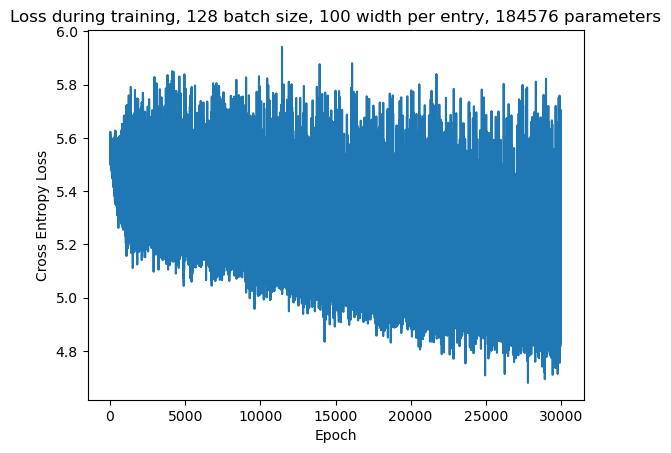

In [18]:
parameter_number = sum(p.numel() for p in model.parameters())

plt.plot(epochs, training_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss during training, " + str(batch_size) + " batch size, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
#plt.ylim(bottom = 0)
plt.show()

C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


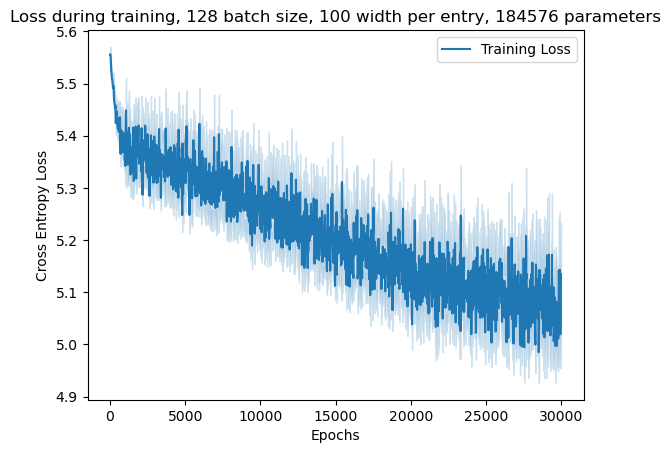

In [19]:
# Produce Seaborn plots, smoothing out train error. Note that they only work when the number of epochs is divided exactly by the moving_avg

parameter_number = sum(p.numel() for p in model.parameters())

# Taking values from nearby epochs and averaging
moving_avg = 20 # The size of the averaging window being used.
epochs = np.arange(0, num_epochs - num_epochs%moving_avg,1)
#training_loss = training_loss[:-1]
reshaped_training_loss = np.reshape(training_loss, (-1, moving_avg)) #note that if the length of training_loss is not divisible by 10, the final elements are ignored
reshaped_epochs = np.reshape(epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

pandas_df = pd.DataFrame({'Training Loss': reshaped_training_loss.flatten(), 'Epochs': repeated_filtered_epochs})
pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = ['Training Loss'], var_name='line', value_name = 'Values')


sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title("Loss during training, " + str(batch_size) + " batch size, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.legend(loc='best')
plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
# Resets the weights of a model using a predefined function

reset_weights(model)

In [ ]:
# Creates line plots of all elements of the accuracy array. Ridiculously unreadable. Might be useful for later modification though

# Creates a plot of the accuracy array
#eps = 10 ** (-300)
#maximum = 10 ** 2
#accuracy_array[np.isnan(accuracy_array)]=0
#accuracy_array[np.abs(accuracy_array) < eps] = 0
#accuracy_array[np.abs(accuracy_array) > maximum] = 0
rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

# Create an axis object for the line plot
fig, ax = plt.subplots()

# Plot each column (program) as a separate line
for i in range(accuracy_array.shape[1]):
    ax.plot(rel_epochs, accuracy_array[:, i], label='Program {}'.format(i+1))

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Plot')
ax.legend()  # Show the legend with program labels

# Show the plot
plt.show()

C:\Users\plogo\AppData\Local\Temp\ipykernel_16356\163844392.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (256).

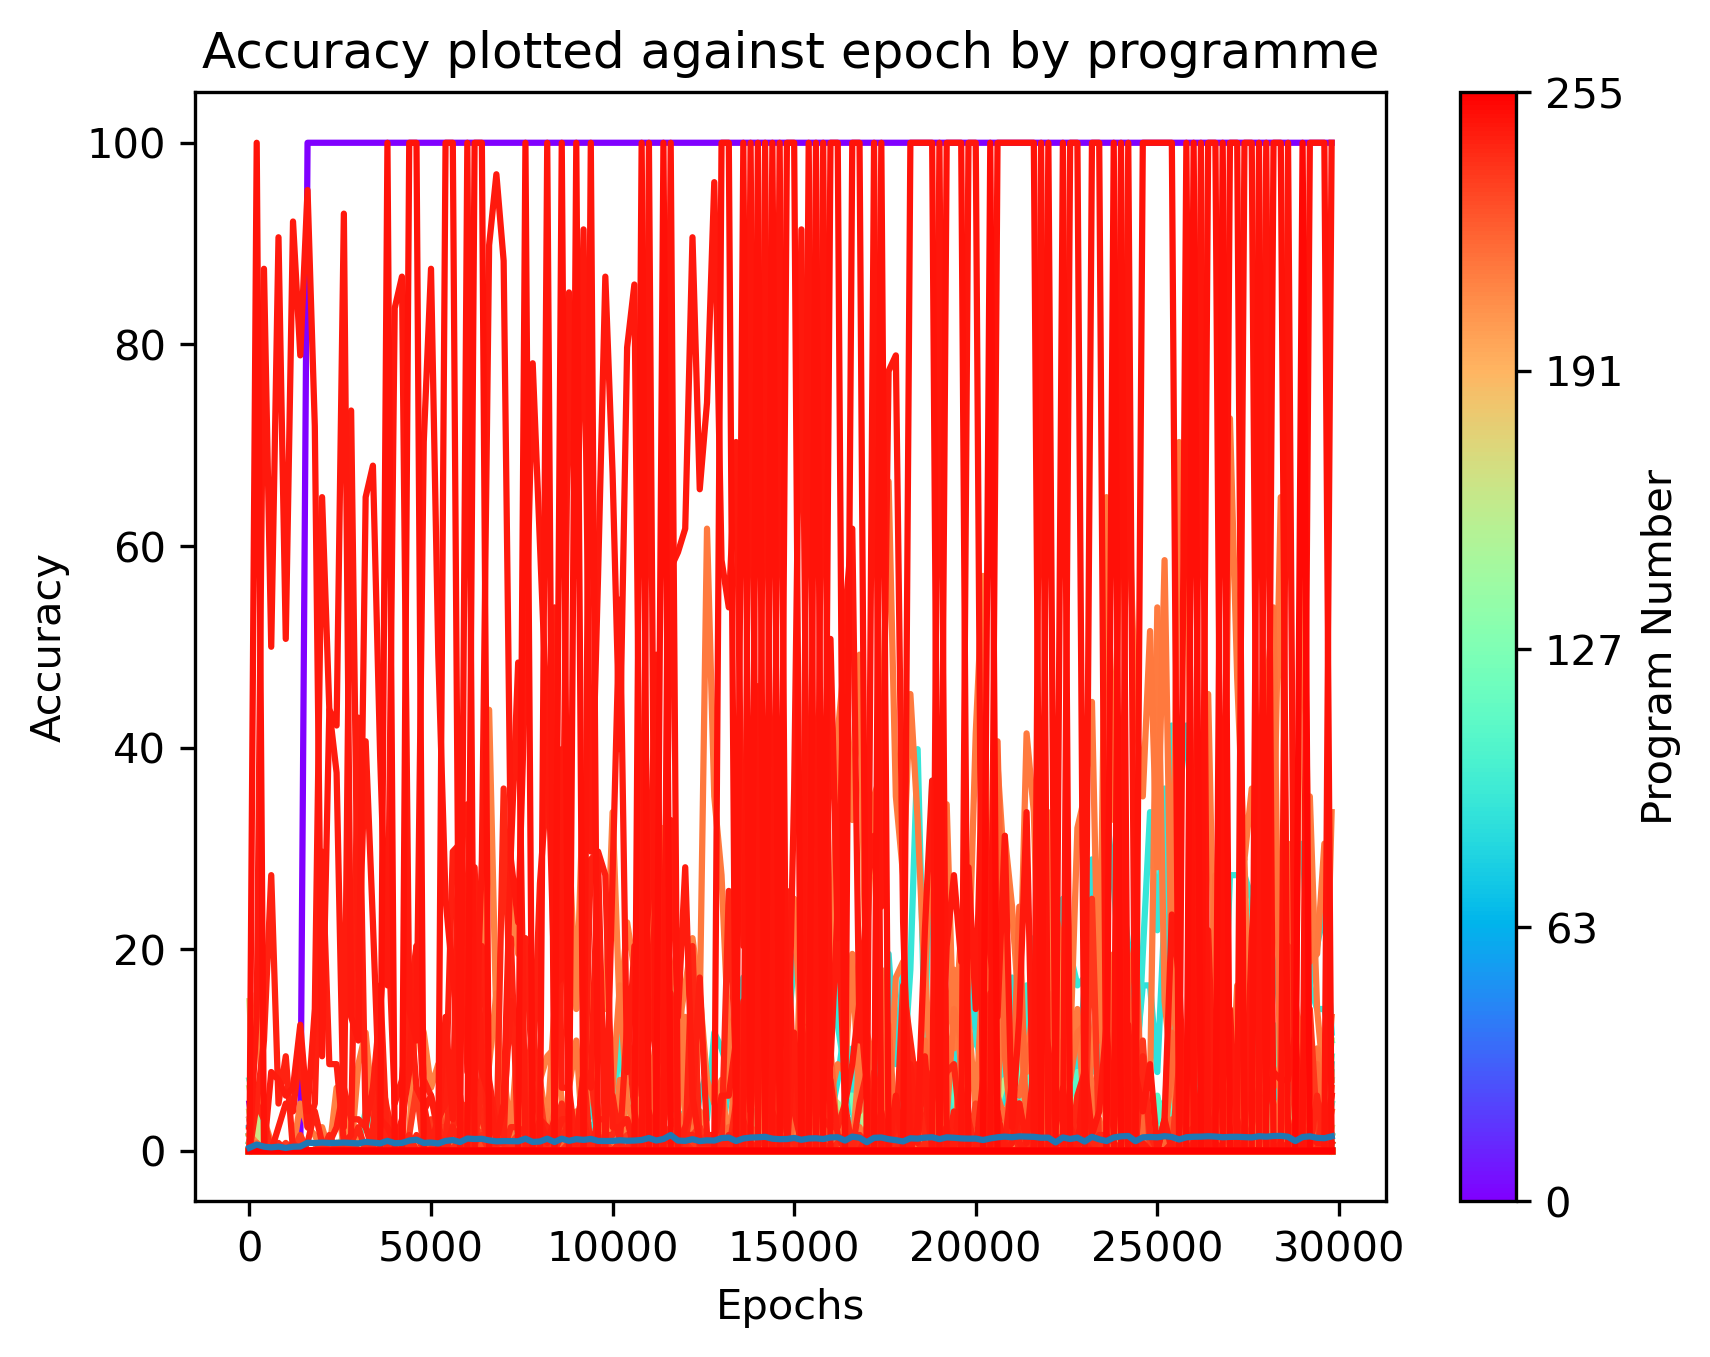

In [22]:
# NOTE - Use later code preferentially, which does not require all lines to be plot. The lines_plotted variable should be altered instead.

# Producing colourmap plots for dealing with the accuracy array values. Gives plots of accuracy over all programmes for various epoch numbers.

# Preprocessing the accuracy_array. This involves removing nan values, and dealing with floating point errors. Note that the accuracy should never be above 100
#eps = 10 ** (-300)
#maximum = 10 ** 2
#accuracy_array[np.isnan(accuracy_array)]=0
#accuracy_array[np.abs(accuracy_array) < eps] = 0
#accuracy_array[np.abs(accuracy_array) > maximum] = 0
# Finding the relevant epochs for the x axis
rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]
# Create an axis object for the line plot
fig, ax = plt.subplots()
# Define a colormap
cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

# Plot each row (program) as a separate line with colormap
for i in range(accuracy_array.shape[1]):
    color = cmap(i / (accuracy_array.shape[1] - 1))  # Generate color from colormap
    ax.plot(rel_epochs, accuracy_array[:,i], color=color, label='Program {}'.format(i+1))

average_accuracy = average_accuracy_func(accuracy_array)
ax.plot(rel_epochs, average_accuracy, label='Average Accuracy')

# Set labels and title for the plot
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy plotted against epoch by programme')

# Create a ScalarMappable object for the colorbar
norm = plt.Normalize(0, accuracy_array.shape[1] - 1)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Set an empty array to associate with the colorbar

# Create a colorbar using the 'ax' argument
cbar = plt.colorbar(sm, ax=ax)

# Set label and ticks for the colorbar
cbar.set_label('Program Number')
cbar.set_ticks(np.linspace(0, accuracy_array.shape[1] - 1, 5, dtype=int))  # Set tick positions
cbar.set_ticklabels(np.arange(accuracy_array.shape[1]) + 1)  # Set tick labels

# Show the plot
plt.show()

#print(len(ax.lines)) # Gives the number of lines printed

In [ ]:
# IMPORTANT - This code is designed to recover the accuracy array from printed outputs in their current form (18/02/2024)
# If the nature of printed outputs changes, this code will cease to work. Hopefully, the array will be recorded properly in future and this will be unnecessary.

# Read the printed output from a text file
file_path = 'Last run - Stored outputs.txt'
with open(file_path, 'r') as file:
    printed_output = file.read()

# Split the printed output into lines
lines = printed_output.strip().split('\n')

# Initialize variables
accuracy_block = False
accuracy_data = []
accuracy_block_data = []

# Process each line
for line in lines:
    if line.startswith("For programme"):
        accuracy_block = True
        accuracy = float(line.split('=')[1].strip())
        accuracy_block_data.append(accuracy)
    elif line.startswith("Epoch"):
        if accuracy_block:
            accuracy_data.append(accuracy_block_data)
            accuracy_block_data = []
        accuracy_block = False
# Convert accuracy data to a NumPy array
accuracy_array = np.array(accuracy_data)

# Print the resulting array
print(accuracy_array)
print(len(accuracy_array))
#print(printed_output)
#print(lines)

In [21]:
# Calculating average accuracy from the accuracy array. Should appear as a vector

def average_accuracy_func(accuracy_array):
    average_accuracy = np.zeros(len(accuracy_array))
    avg_acc = 0
    for i in range(len(accuracy_array)):
        row = accuracy_array[i]
        avg_acc = sum(row) / len(row)
        average_accuracy[i] = avg_acc
    return average_accuracy

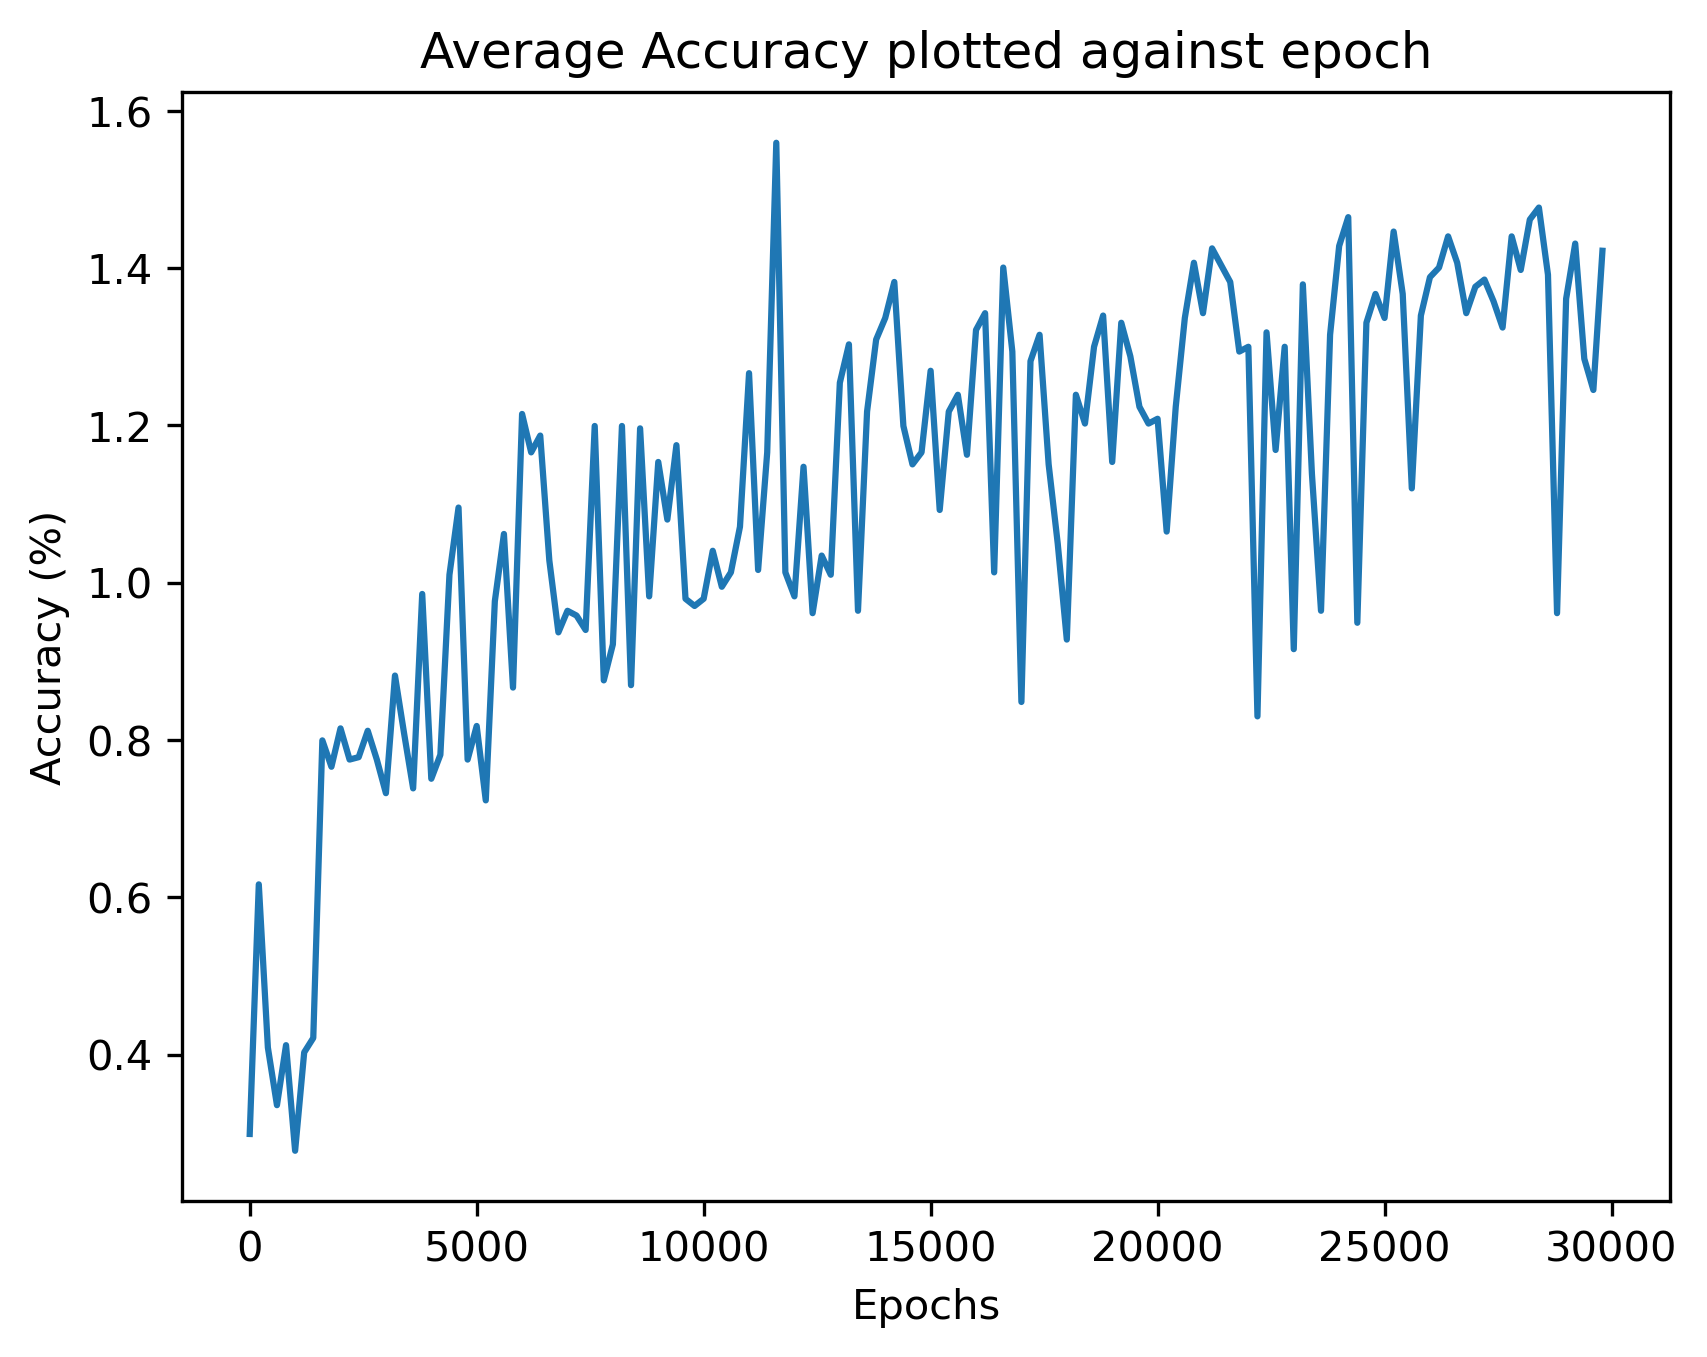

In [23]:
# Plotting average accuracy

epochs = np.arange(0, num_epochs, 1)
rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]
#accuracy_array = accuracy_array_copy
#accuracy_array = accuracy_array[:-1]

average_accuracy = average_accuracy_func(accuracy_array)
plt.plot(rel_epochs, average_accuracy, label='Average Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy plotted against epoch')

plt.show()

In [24]:
average_accuracy = average_accuracy_func(accuracy_array)

rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

# Taking values from nearby epochs and averaging
#moving_avg = 5 # The size of the averaging window being used.
epochs = np.arange(0, num_epochs - num_epochs%moving_avg,1)
#training_loss = training_loss[:-1]
reshaped_avg_acc = np.reshape(average_accuracy, (-1, moving_avg)) #note that if the length of training_loss is not divisible by 10, the final elements are ignored
reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

pandas_df = pd.DataFrame({'Average Accuracy': reshaped_avg_acc.flatten(), 'Epochs': repeated_filtered_epochs})
pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = ['Average Accuracy'], var_name='line', value_name = 'Values')


sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line')
plt.xlabel('Epochs')
plt.ylabel('Average accuracy plotted against epoch')
#plt.title("Loss during training, " + str(batch_size) + " batch size, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.legend(loc='best')
plt.rcParams['figure.dpi'] = 300
plt.show()

ValueError: cannot reshape array of size 150 into shape (20)

[95.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  7.  0.  0.
  1.  8.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  5.  1.  9. 18.
  0.  3.  0.  0.  2.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  0.  1.  3.  2.  6.  8

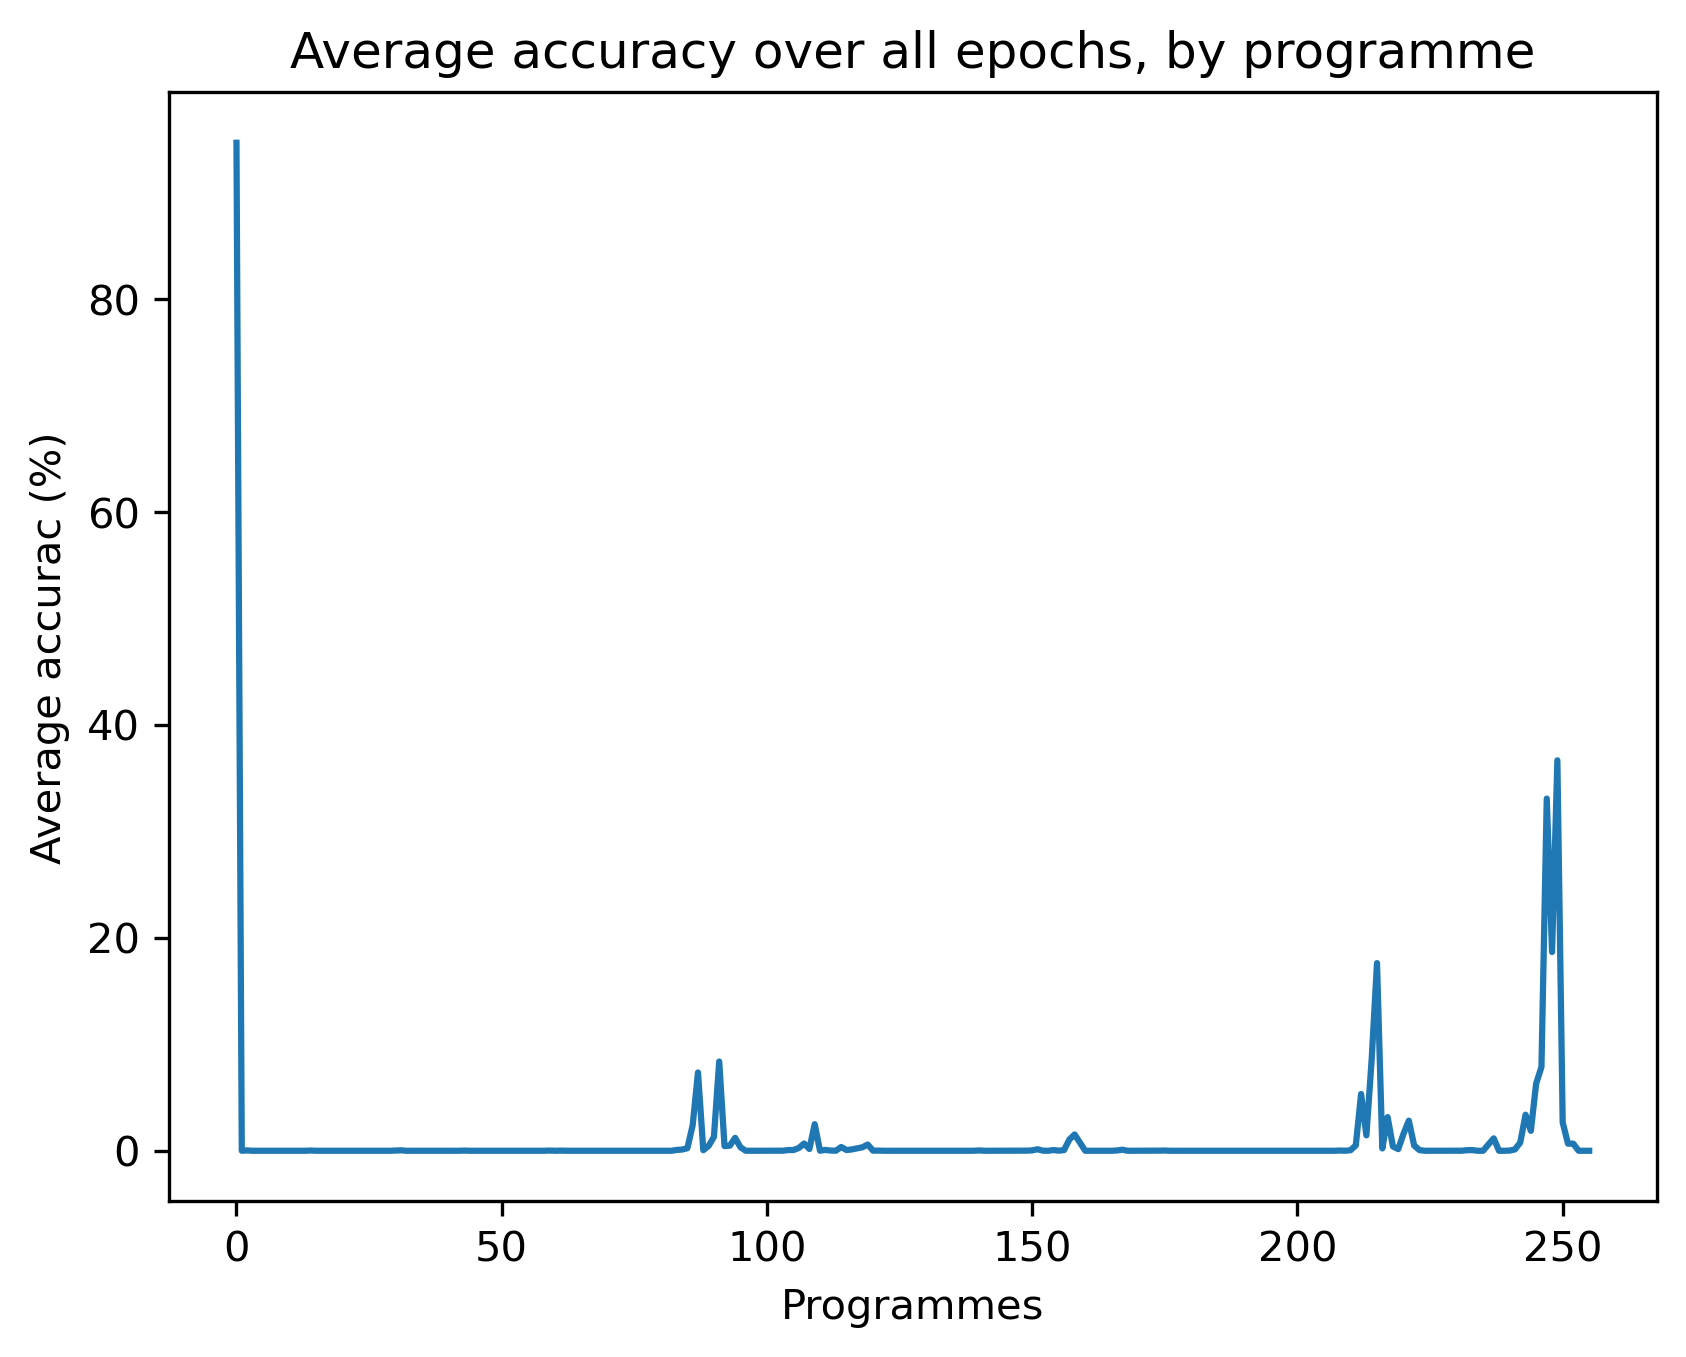

(array([  0,  86,  87,  90,  91,  94, 109, 157, 158, 212, 213, 214, 215,
       217, 220, 221, 237, 243, 244, 245, 246, 247, 248, 249, 250],
      dtype=int64),)
Programmes sorted by highest accuracy:  [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 33, 34, 36, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 96, 97, 98, 99, 100, 101, 102, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 153, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 173, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 224, 225, 226, 227, 228, 229, 230, 234, 235, 238, 239, 253, 254, 255, 10, 23, 37, 54, 68, 76, 103, 110, 113, 147, 148, 172, 209, 231, 35, 56, 61, 120, 149, 152, 155, 

In [25]:
# Calculates the average accuracy for each programme, when averaged over all epochs

column_averages = np.mean(accuracy_array, axis=0)

print(np.round(column_averages, 0))

programmes_considered = np.arange(0, 256, 1)

plt.plot(programmes_considered, column_averages)
plt.xlabel('Programmes')
plt.ylabel('Average accurac (%)')
plt.title('Average accuracy over all epochs, by programme')
plt.show()

easily_learned = np.where(column_averages > 1)
print(easily_learned)
sortedbyacc = [x for _, x in sorted(zip(column_averages, programmes_considered))]
print(f"Programmes sorted by highest accuracy: ", sortedbyacc)

C:\Users\plogo\AppData\Local\Temp\ipykernel_16356\3554829129.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


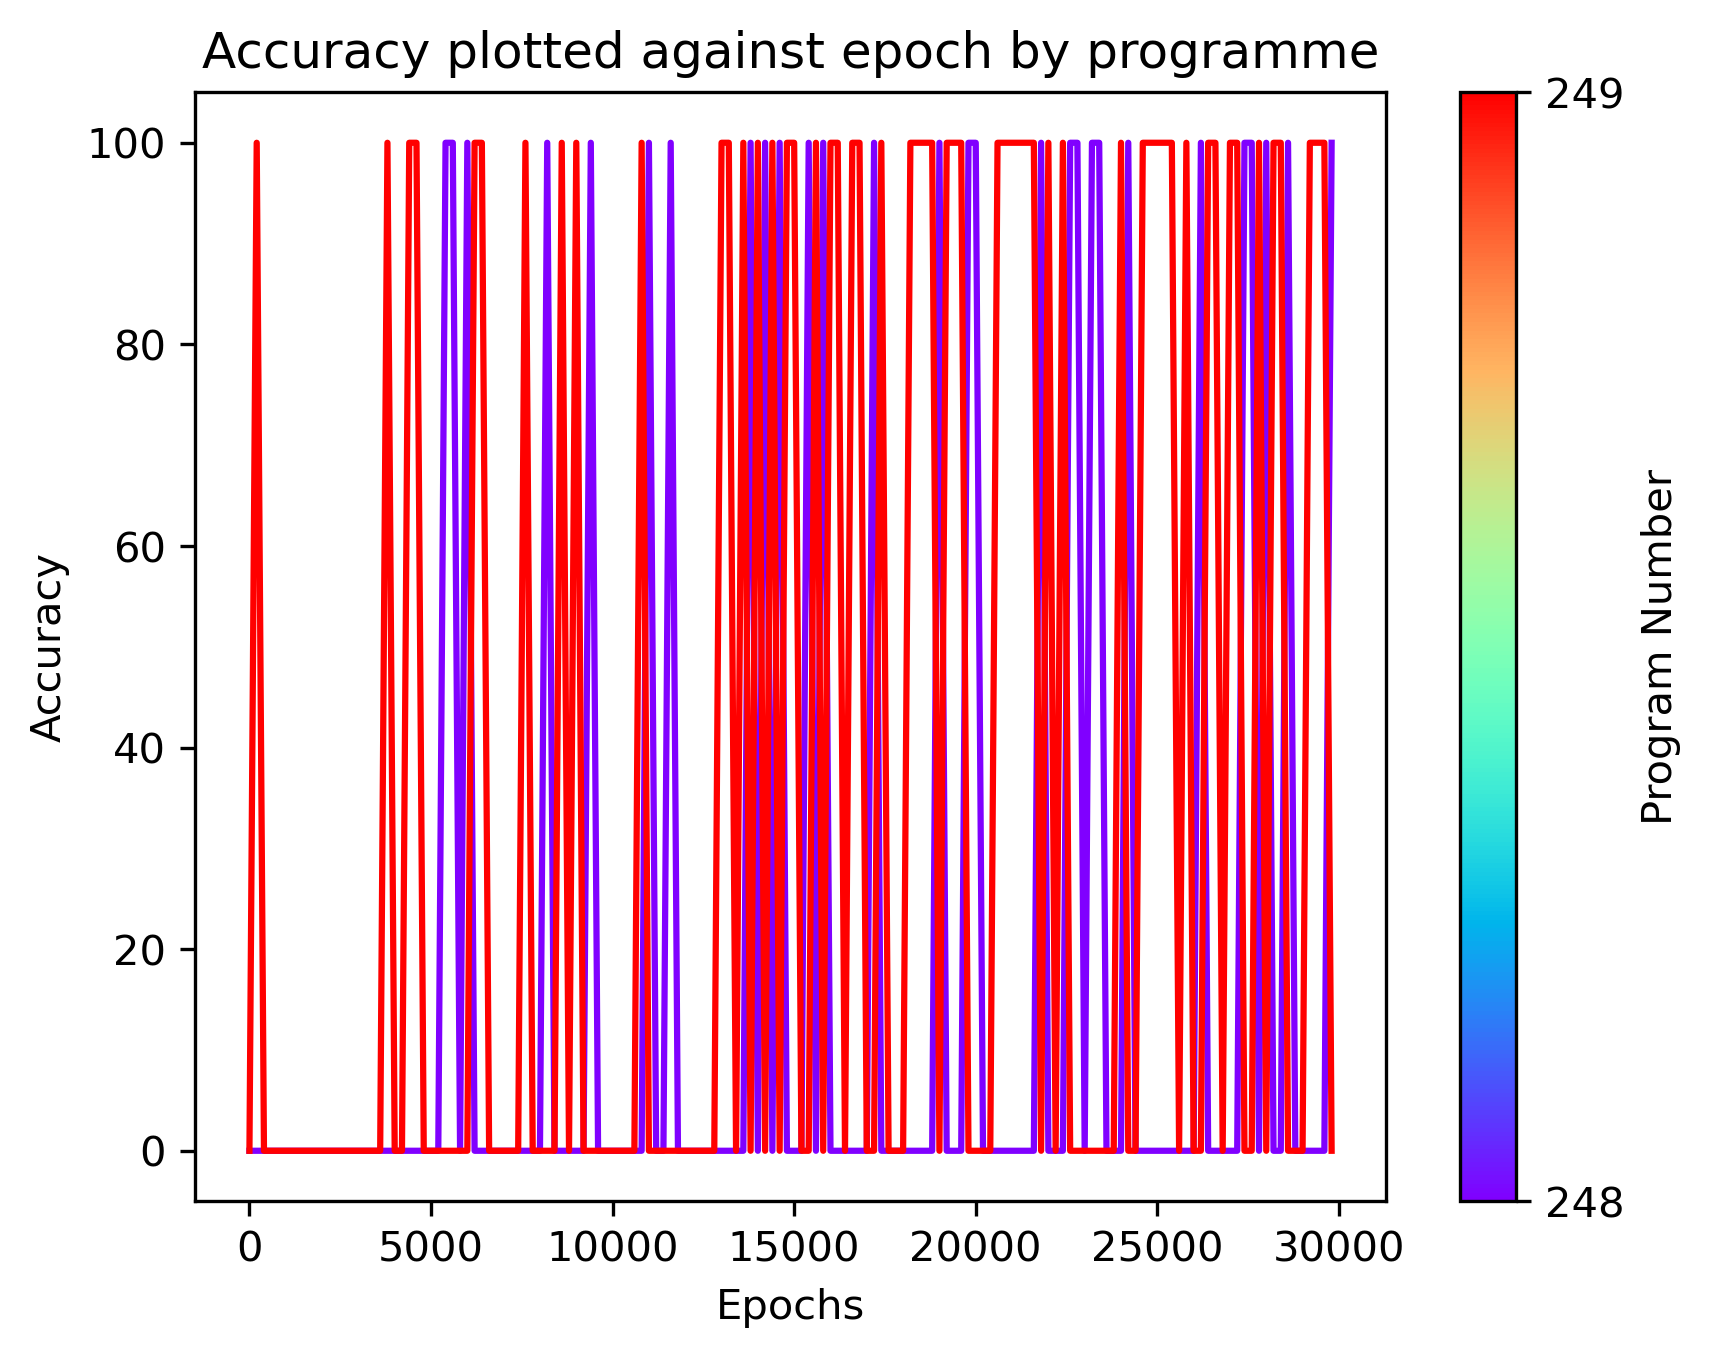

In [29]:
# Create a plot with a variable number of lines

#lines_plotted = np.arange(60, 101, 1)
#hard_learned_array = np.array(hard_learned_list)
uncorr_list = sorted([248, 249])
uncorr_array = np.array(uncorr_list)
lines_plotted = uncorr_array

epochs = np.arange(0, num_epochs, 1)
rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

# Create an axis object for the line plot
fig, ax = plt.subplots()

# Define a colormap
cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

# Plot each row (program) as a separate line with colormap
for i in lines_plotted:
    color = cmap(np.where(lines_plotted==i)[0][0] / (len(lines_plotted) - 1))  # Generate color from colormap
    ax.plot(rel_epochs, accuracy_array[:,i], color=color, label='Program {}'.format(i+1))

#average_accuracy = average_accuracy_func(accuracy_array)
#ax.plot(rel_epochs, average_accuracy, label='Average Accuracy')

# Set labels and title for the plot
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy plotted against epoch by programme')

# Create a ScalarMappable object for the colorbar
norm = plt.Normalize(0, len(lines_plotted) - 1)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Set an empty array to associate with the colorbar

# Create a colorbar using the 'ax' argument
cbar = plt.colorbar(sm, ax=ax)

# Set label and ticks for the colorbar
cbar.set_label('Program Number')
#cbar.set_ticks(np.linspace(0, len(lines_plotted) - 1, 11, dtype=int))  # Set tick positions
#cbar.set_ticklabels(np.arange(len(lines_plotted)))  # Set tick labels

num_ticks = len(lines_plotted)  # Number of desired ticks
indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
tick_positions = indices
tick_labels = lines_plotted[indices]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

# Show the plot
plt.show()


In [ ]:
# Creating a seaborn plot of the accuracy plots for improved visibility

#rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
rel_list = sorted([243, 244, 249, 90, 0, 246, 247, 245])
rel_array = np.array(rel_list)
#lines_plotted = uncorr_array[0:3]
#lines_plotted = rel_array[2: 5]
uncorr_array = rel_array
lines_plotted = rel_array

#rel_programmes = np.asarray(np.where(programmes_prob_distribution != 0))
#uncorr_array = np.array(rel_programmes)
#lines_plotted = uncorr_array[2:5]

#lines_plotted = rel_programmes[0:3]

rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

# Create an axis object for the line plot
fig, ax = plt.subplots()
cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

# Taking values from nearby epochs and averaging
moving_avg = 10 # The size of the averaging window being used.
reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

for i in tqdm(lines_plotted):
    line = accuracy_array[:,i]
    #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
    #color = cmap(index / (len(lines_plotted) - 1))
    color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
    reshaped_line = np.reshape(line, (-1, moving_avg))
    programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
    pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
    pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
    #fig, ax = plt.subplots()
    sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color])

# Create a ScalarMappable object for the colorbar
norm = plt.Normalize(0, len(lines_plotted) - 1)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Set an empty array to associate with the colorbar
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label('Program Number')

num_ticks = len(lines_plotted)  # Number of desired ticks
indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
tick_positions = indices
tick_labels = lines_plotted[indices]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

ax.get_legend().remove()

plt.ylabel('Accuracy (%)')

plt.show()

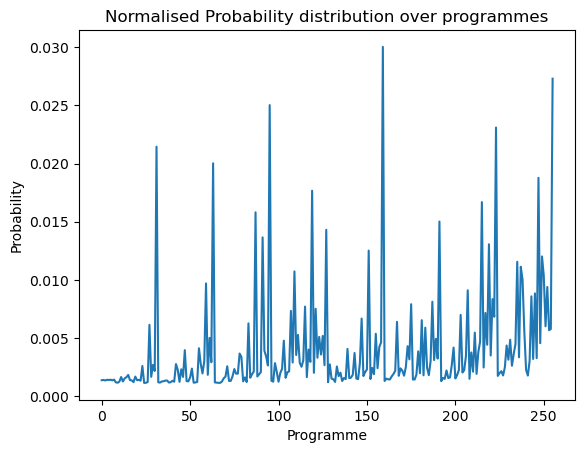

In [7]:
# Plot the programmes probabililty distribution

#programmes_prob_distribution = prog_dist_bell(128, 32)
#programmes_prob_distribution = prog_dist_uncorr()
prog_prob_dist_norm = [x / sum(programmes_prob_distribution) for x in programmes_prob_distribution]
programmes_considered_ = np.arange(0, 256, 1)

plt.plot(programmes_considered_, prog_prob_dist_norm)

plt.xlabel('Programme')
plt.ylabel('Probability')
plt.title('Normalised Probability distribution over programmes')
plt.show()

In [463]:
indep_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38,
              40, 41, 42, 43, 44, 45, 46, 50, 51, 54, 56, 57, 58, 60, 62, 72, 73, 74, 76, 77, 78, 90, 94, 104, 105, 106, 108, 110, 122, 126, 
              128, 130, 132, 134, 136, 138, 140, 142, 146, 150, 152, 154, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232]

In [ ]:
hard_learned_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 19, 22, 23, 24, 26, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 
                     45, 46, 51, 54, 56, 60, 72, 73, 74, 76, 78, 90, 104, 106, 108, 110, 122, 126, 128, 130, 132, 134, 138, 140, 142, 146, 150, 
                     152, 154, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232]

In [54]:
uncorr_list = [0, 30, 55, 90, 124, 158, 188, 202, 219, 221, 248]

In [221]:
print(prog_prob_dist_norm[1])

0.0057752436479053875


In [6]:
# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = 256 #Number of potential classes, here stuck at 256

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

pytorch_total_params = sum(p.numel() for p in model.parameters())

print(pytorch_total_params)

184576
